# Project 4: Predicting West Nile Virus
## Team Purple Cobras - General Assembly Boston - DSI
## September 2018

# EDA Notebook

Goal: Build a classification model to predict where and when West Nile Virus will be found in Chicago.

The purpose of this notebook is to contain my initial EDA, notes, and data cleaning. The goal is to figure out how to clean the data, write a function (or multiple functions, or a script) to do so, and to begin visualizing the data to understand relationships before building a model.

In [37]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.display.max_columns = 1000

In [38]:
# read in datasets
train = pd.read_csv('../data/train.csv')
spray = pd.read_csv('../data/spray.csv')
weather = pd.read_csv('../data/weather.csv')

# EDA Part 1: Inspect the Data

In [39]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [40]:
nulls = spray['Time'].isnull()
spray[nulls]['Date'].unique()

spray[~nulls]['Date'].unique()

array(['2011-08-29', '2011-09-07', '2013-07-17', '2013-07-25',
       '2013-08-08', '2013-08-15', '2013-08-16', '2013-08-22',
       '2013-08-29', '2013-09-05'], dtype=object)

First thing I notice here is that there are 584 missing values (~4% of the data) in the 'Time' column of the spray data, all of which are from September 7th, 2011 (not MCAR). Intuitively, I don't think this is a huge deal, as time of day is a very specific detail and I wouldn't expect it to make a big difference. However, I will investigate further to decide how best to handle the nulls.

Based on how the data seems to be ordered (BnL chronologically) and where the data appears to be missing (between 7:44 and 7:46pm, I think it is reasonable to interpolate and enter in a value of 7:45pm for these data points. I may revisit this assumption later if it turns out that the result rely too heavily on this assumption being correct.

In [41]:
spray.fillna('7:45:00 PM', inplace = True)

In [42]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [44]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [45]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,10506.0,35.687797,24.339468,10.000000,12.000000,33.000000,52.000000,98.000000
Latitude,10506.0,41.841139,0.112742,41.644612,41.732984,41.846283,41.954690,42.017430
Longitude,10506.0,-87.699908,0.096514,-87.930995,-87.760070,-87.694991,-87.627796,-87.531635
AddressAccuracy,10506.0,7.819532,1.452921,3.000000,8.000000,8.000000,9.000000,9.000000
NumMosquitos,10506.0,12.853512,16.133816,1.000000,2.000000,5.000000,17.000000,50.000000
WnvPresent,10506.0,0.052446,0.222936,0.000000,0.000000,0.000000,0.000000,1.000000


In [46]:
train['WnvPresent'].value_counts(normalize = True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [47]:
train['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [48]:
cpr = train['Species'] == 'CULEX PIPIENS/RESTUANS'
train[cpr].count()

Date                      4752
Address                   4752
Species                   4752
Block                     4752
Street                    4752
Trap                      4752
AddressNumberAndStreet    4752
Latitude                  4752
Longitude                 4752
AddressAccuracy           4752
NumMosquitos              4752
WnvPresent                4752
dtype: int64

# Notes

1. This is clearly a very unbalanced dataset, with only 5% of the data representing True Positives. We will have to decide how to address this. At the very least, it will be vital to ensure we stratify our train-test split.
2. Per the data description and my observations, the number of mosquitoes is capped at 50 - a new row is created if the number of mosquitoes exceeds 50. I'm not sure this makes sense - we may want to just combine the rows to get a more accurate representation of the real data.
3. There appear to be six different species of mosquito. For some reason, almost half the data are recorded as 'Culex Pipiens/Restuans.' Maybe this means both species were found? Might be worth creating dummies for the presence of each type. From outside research, Culex Pipiens are the most populous of the Culex mosquitoes, and are the primary carriers of West Nile Virus (http://www.mosquitoworld.net/about-mosquitoes/species/)

In [49]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [50]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [51]:
weather.describe().T

,count,mean,std,min,25%,50%,75%,max
Station,2944.0,1.500000,0.500085,1.0,1.0,1.5,2.0,2.0
Tmax,2944.0,76.166101,11.461970,41.0,69.0,78.0,85.0,104.0
Tmin,2944.0,57.810462,10.381939,29.0,50.0,59.0,66.0,83.0
DewPoint,2944.0,53.457880,10.675181,22.0,46.0,54.0,62.0,75.0
ResultSpeed,2944.0,6.960666,3.587527,0.1,4.3,6.4,9.2,24.1
ResultDir,2944.0,17.494905,10.063609,1.0,7.0,19.0,25.0,36.0


# Note:

There are a number of issues with the 'Weather' data. Many of the 'numeric' columns are saved as 'object' due to how non-numeric values were entered. 'Missing' data, for example, seems to be marked 'M.' In order to use the weather data, we will need to understand what the non-numeric values represent, and what to do about them.

There is also the open question of how the weather data and spray data can be merged into the 'main' dataset.

# Note:

The cells below are some extra EDA I did after initially writing my data cleaning function, to take a closer look at how much 'missing' data there is for each Station.

In [52]:
weather_2 = weather.drop(columns = ['Depth', 'Water1', 'SnowFall']) # Drop wholly useless columns
weather_3 = weather_2.replace({'T': 0.0, '  T': 0.0, 'M': np.nan, '-': np.nan}) # Replace 'string' entries
weather_3.info() # See how many non-null values there are

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 19 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2933 non-null object
Depart         1472 non-null object
DewPoint       2944 non-null int64
WetBulb        2940 non-null object
Heat           2933 non-null object
Cool           2933 non-null object
Sunrise        1472 non-null object
Sunset         1472 non-null object
CodeSum        2944 non-null object
PrecipTotal    2942 non-null object
StnPressure    2940 non-null object
SeaLevel       2935 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2941 non-null object
dtypes: float64(1), int64(5), object(13)
memory usage: 437.1+ KB


In [53]:
stn_1 = weather_3[weather_3['Station'] == 1] # Filter one df for Station 1 only
stn_2 = weather_3[weather_3['Station'] == 2] # Filter another for Station 2

In [54]:
stn_2.drop(columns = ['Depart','Sunrise','Sunset'], inplace = True) # Drop columns for which Stn 2 has no data
stn_2.info() # examine Stn 2 data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 1 to 2943
Data columns (total 16 columns):
Station        1472 non-null int64
Date           1472 non-null object
Tmax           1472 non-null int64
Tmin           1472 non-null int64
Tavg           1461 non-null object
DewPoint       1472 non-null int64
WetBulb        1471 non-null object
Heat           1461 non-null object
Cool           1461 non-null object
CodeSum        1472 non-null object
PrecipTotal    1470 non-null object
StnPressure    1470 non-null object
SeaLevel       1468 non-null object
ResultSpeed    1472 non-null float64
ResultDir      1472 non-null int64
AvgSpeed       1469 non-null object
dtypes: float64(1), int64(5), object(10)
memory usage: 195.5+ KB


/Users/Katrina/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [55]:
stn_1.info() # examine Stn 1 data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 2942
Data columns (total 19 columns):
Station        1472 non-null int64
Date           1472 non-null object
Tmax           1472 non-null int64
Tmin           1472 non-null int64
Tavg           1472 non-null object
Depart         1472 non-null object
DewPoint       1472 non-null int64
WetBulb        1469 non-null object
Heat           1472 non-null object
Cool           1472 non-null object
Sunrise        1472 non-null object
Sunset         1472 non-null object
CodeSum        1472 non-null object
PrecipTotal    1472 non-null object
StnPressure    1470 non-null object
SeaLevel       1467 non-null object
ResultSpeed    1472 non-null float64
ResultDir      1472 non-null int64
AvgSpeed       1472 non-null object
dtypes: float64(1), int64(5), object(13)
memory usage: 230.0+ KB


# Cleaning the Weather Data

Below is a function to clean the weather dataset into a useable form. The following assumptions were used to fill in missing values and ensure all numeric columns were of type 'float':

1. 'M' indicates missing data and should be replaced with NaN
2. 'T' for 'trace' amounts of precipitation indicates a very small amount (below a certain threshold) which can safely be replaced with 0.0 (CITATION NEEDED).
3. If one weather station did not record a value for a particular column on a given day, we will use the reading from the other station (if there is one) as this is our 'best guess' for the approximate value. We are relying on the assumption that the values will not differ by enough between stations to meaningfully alter our results. This is probably our weakest assumption, and one that we may want to revisit later.

In [56]:
# Create a function to clean the weather data
def clean_weather_data(data):
    '''Returns a cleaned copy of the weather data from each station'''
    
    # Convert 'Date' column to a datetime object
    data['Date'] = pd.to_datetime(data['Date'])
        
    # Drop unnecessary columns
    data.drop(columns = ['Depth', 'Water1', 'SnowFall'], inplace = True)
    
    # Replace values of 'T' with 0.0 and 'M' with nan
    data.replace({'T': 0.0, '  T': 0.0, 'M': np.nan, '-': np.nan}, inplace = True)
    
    # Fill 'na' values with the non-missing counterpart
    clean_data = data.groupby('Date', as_index = False).fillna(method = 'pad').fillna(method = 'backfill')
    
    # Convert numeric types to float where possible
    cleaner_data = clean_data.apply(lambda c: c.astype('float64', errors = 'ignore'))
    
    # Create a dataframe that averages the two
    weather_num = cleaner_data.loc[:, weather.columns != 'CodeSum']
    weather_avg = weather_num.groupby('Date').aggregate(np.mean)
    weather_avg.reset_index(inplace = True)
    
    # Split into Station 1 and Station 2 data
    stn_1 = cleaner_data[cleaner_data['Station'] == 1]
    stn_1.reset_index(inplace = True)
    
    stn_2 = cleaner_data[cleaner_data['Station'] == 2] 
    stn_2.reset_index(inplace = True)
    
    # Drop columns for which Stn 2 has no data
    stn_2.drop(columns = ['Depart','Sunrise','Sunset'], inplace = True)
    
    # Add back CodeSum columns from Stn 1 and 2 to the average df
    weather_avg['CodeSum_s1'] = stn_1['CodeSum']
    weather_avg['CodeSum_s2'] = stn_2['CodeSum']
    
    # Create single Codesum column for the average df
    weather_avg['CodeSum'] = weather_avg[['CodeSum_s1', 'CodeSum_s2']].apply(lambda x: ''.join(x), axis=1)
    weather_avg.drop(columns = ['CodeSum_s1','CodeSum_s2'], inplace = True)
    
    return stn_1, stn_2, weather_avg

# Cleaning Training Data

There is one issue with the training data that needs to be explored/fixed. Per the kaggle instructions, in cases where the number of mosquitos is > 50, a new row was created to hold the 'spillover' data. For our purposes, it doesn't make sense to keep these rows separate, so I'll aggregate by adding the observations.

In [57]:
def clean_main_data(data):
    '''Returns a cleaned main (train or test) dataset, sums the number of mosquitos for all identical rows'''
    
    # Convert 'Date' column to a datetime object
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Columns to GroupBy - everything but NumMosquitos
    columns = ['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'WnvPresent']

    # Sum the number of mosquitos by group
    data_clean = pd.DataFrame(train.groupby(columns, as_index = False)['NumMosquitos'].sum())
    
    return data_clean

# Adding Weather Data to Main Dataset - Full Preprocessing

Once the weather data has been appropriately cleaned we can pass the main (train or test) dataset and the weather station data into a function that merges the weather data onto the main data (by Date) and returns a full dataframe that is ready for EDA/Modeling.

In [58]:
def preprocess_data(main, weather):
    '''Returns preprocessed, cleaned data frames combining main (train or test) and weather data'''
    
    # Clean the train or test data
    main_clean = clean_main_data(main)
    
    # Clean the weather data, add them to a list
    station_1, station_2, weather_avg = clean_weather_data(weather)
    
    # Merge the weather and main data, returning full dataframes
    full_s1 = main_clean.merge(station_1, how = 'left', on = 'Date')
    full_s2 = main_clean.merge(station_2, how = 'left', on = 'Date')
    full_avg = main_clean.merge(weather_avg, how = 'left', on = 'Date')
    
    return full_s1, full_s2, full_avg

In [59]:
full_s1, full_s2, full_avg = preprocess_data(train, weather)

/Users/Katrina/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [61]:
# Export the clean data to csv so I can import it into other notebooks
full_avg.to_csv('../data/clean_data', index = False)

In [65]:
type(full_avg["Date"][0])

pandas._libs.tslibs.timestamps.Timestamp

# EDA Part 2: Visualize the Data

In [25]:
full_avg['NumMosquitos'].describe()

count    8610.000000
mean       15.683972
std        68.560634
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max      2206.000000
Name: NumMosquitos, dtype: float64

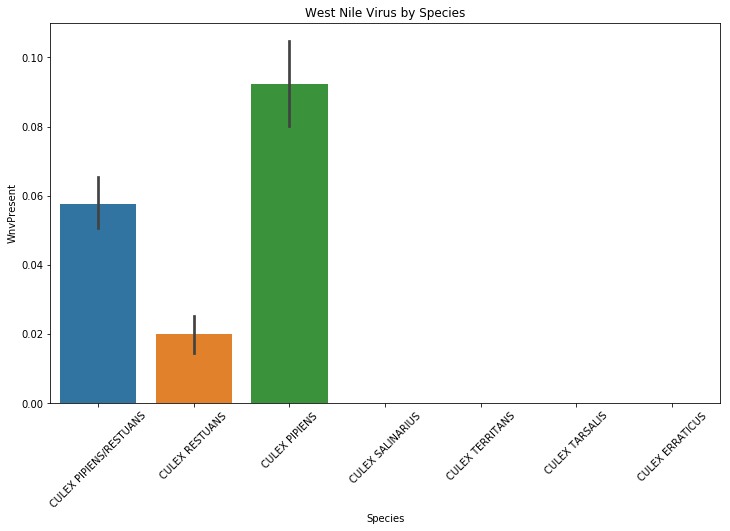

In [26]:
plt.figure(figsize = (12,7))
plt.xticks(rotation = '45')
plt.title('West Nile Virus by Species')
sns.barplot(x = 'Species', y = 'WnvPresent', data = full_avg);

This is a useful early finding. Only three of the 'species' categories (and two of the species) are associated with West Nile Virus.

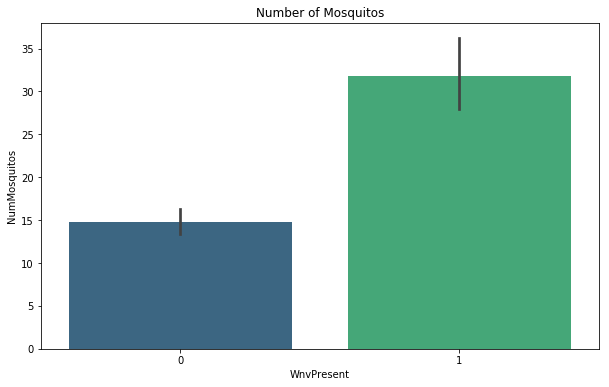

In [27]:
plt.figure(figsize = (10,6))
plt.title('Number of Mosquitos')
sns.barplot(x = 'WnvPresent', y = 'NumMosquitos', data = full_avg, palette = 'viridis');

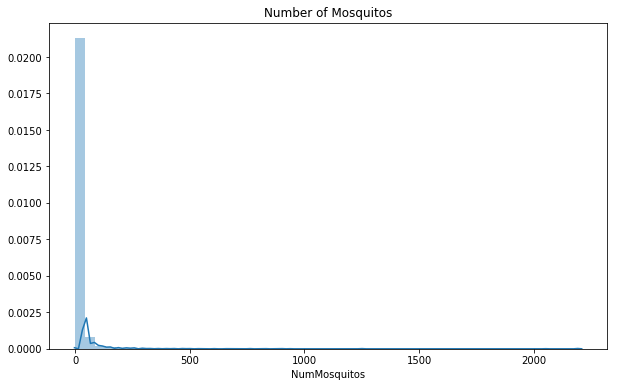

In [28]:
plt.figure(figsize = (10,6))
plt.title('Number of Mosquitos')
sns.distplot(full_avg['NumMosquitos']);

As expected, Number of mosquitos appears to be a good predictor of West Nile Virus. After aggregating the multiple rows in cases where the number of mosquitos exceeds 50, it's clear that the distribution is extremely skewed to the right by some observations that contain and extremely high number of mosquitos. This may cause a problem when it comes to modeling, so it could be prudent to do something about this. One suggestion is to a form of Winsorizing, cap the number (at 50, or some high percentile) and just set any values above that cap equal to the cap. Otherwise it may be difficult to get anything meaningful out of the data.

In [29]:
from scipy.stats.mstats import winsorize

# Winsorize the NumMosquitos column, cap right tail at 95th percentile
winsorize(full_avg['NumMosquitos'], limits = (None, 0.05), inplace = True)

full_avg['NumMosquitos'].describe()

count    8610.000000
mean        9.826829
std        13.387949
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max        50.000000
Name: NumMosquitos, dtype: float64

Interestingly enough, the 95th percentile of the number of mosquitos happens to be exactly 50. That seems like a reasonable cap.

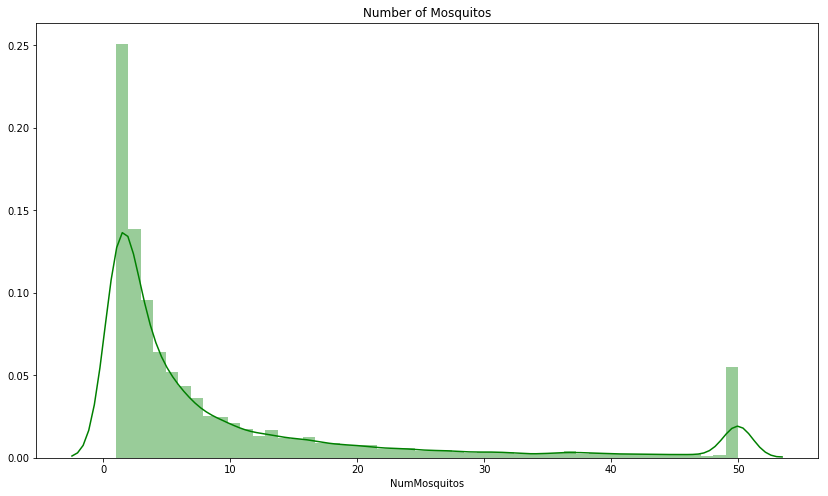

In [30]:
plt.figure(figsize = (14,8))
plt.title('Number of Mosquitos')
sns.distplot(full_avg['NumMosquitos'], color = 'g');

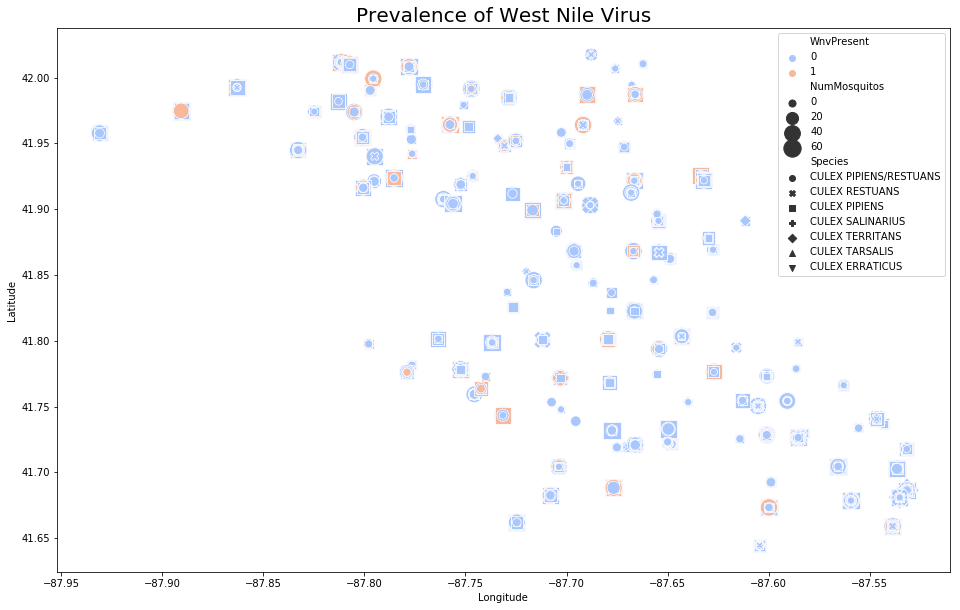

In [31]:
plt.figure(figsize = (16,10))
plt.title('Prevalence of West Nile Virus', fontsize = 20)
sns.scatterplot(x = 'Longitude', y = 'Latitude', hue = 'WnvPresent', data = full_avg, 
                size = 'NumMosquitos', sizes = (50, 300), style = 'Species', palette = 'coolwarm');

In [32]:
full_avg.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,8610.0,38.793380,24.129378,10.000000,14.000000,37.000000,58.000000,98.000000
Latitude,8610.0,41.844422,0.107076,41.644612,41.750498,41.857402,41.944869,42.017430
Longitude,8610.0,-87.695237,0.084921,-87.930995,-87.752411,-87.694991,-87.642984,-87.531635
AddressAccuracy,8610.0,7.936121,1.326695,3.000000,8.000000,8.000000,9.000000,9.000000
WnvPresent,8610.0,0.053078,0.224202,0.000000,0.000000,0.000000,0.000000,1.000000
NumMosquitos,8610.0,9.826829,13.387949,1.000000,2.000000,4.000000,11.000000,50.000000
Station,8610.0,1.500000,0.000000,1.500000,1.500000,1.500000,1.500000,1.500000
Tmax,8610.0,81.374623,8.383319,57.500000,78.000000,83.000000,86.500000,96.500000
Tmin,8610.0,63.120325,7.634631,42.500000,59.000000,65.000000,69.000000,77.500000
Tavg,8610.0,72.488734,7.578527,51.000000,68.500000,73.500000,77.500000,85.500000


In [33]:
full_avg['CodeSum_s1'].unique()

KeyError: 'CodeSum_s1'

In [36]:
full_avg['CodeSum_s2'].unique()

KeyError: 'CodeSum_s2'

Looking at the encodings, all of the types of data we're seeing here appear to be types of precipitation. One simple solution could be to create a dummy where any of the 'Rain' related weather gets a 1 and everything else a 0. Further EDA could potentially elucidate more granular relationships. The below is a very crude implementation. First, I want to do the basic visualization to see if simplifying it to "Precipitation" vs "No Precipitation" is worthwhile, versus keeping the codes as is.

In [ ]:
plt.figure(figsize = (14,7))

plt.xticks(rotation = '45')
plt.title('West Nile Virus by Weather Code')
sns.barplot(x = 'CodeSum', y = 'WnvPresent', data = full_s1);

In [ ]:
plt.figure(figsize = (14,7))

plt.xticks(rotation = '45')
plt.title('West Nile Virus by Weather Code')
sns.barplot(x = 'CodeSum', y = 'WnvPresent', data = full_s2);

Compressing all of the weather codes into 'Precipitation' versus 'No Precipitation' loses a lot of explanatory power. So the individual codes are important, but they probably still need to be dummied. However, after accounting for frequency of each, the signal seems weaker. Appropriate next steps would be to dummy each different code, then see which individual codes and interaction terms work as predictors.

In [ ]:
sns.pairplot(vars = ['Tavg','PrecipTotal','NumMosquitos'], data = full_avg, hue = 'WnvPresent');

In [ ]:
sns.pairplot(vars = ['Tavg','Tmax','Tmin'], data = full_avg, hue = 'WnvPresent');

The scatterplots above suggest that temperature strongly related to presence of West Nile Virus. At higher temperatures, west nile virus is much more likely to be observed.

# Basic Modeling - first attempt

In [ ]:
from sklearn.model_selection import train_test_split

# Set up X and y
features = ['Block', 'Latitude', 'Longitude', 'NumMosquitos', 'Tavg']

X = full_avg[features]
y = full_avg['WnvPresent']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
tree = dt.fit(X_train, y_train)
tree.score(X_test, y_test)

In [35]:
weather

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,NaN,51,57,0,3,NaN,NaN,,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,NaN,42,47,13,0,NaN,NaN,BR HZ,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,NaN,40,50,7,0,NaN,NaN,HZ,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,RA,0,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,NaN,NaN,42,50,NaN,NaN,NaN,NaN,,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,,0,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,NaN,39,50,5,0,NaN,NaN,,0,29.46,30.09,11.2,7,11.5
